## **Catégorisez automatiquement des questions**

### partie 4/8 (suite): Prédiction de tags, approche supervisée, sentence embedding

#### <br> L'objectif de ce notebook est de découvrir des techniques NLP plus avancées: Word2Vec (peut être remplacé par Doc2Vec), BERT, USE

<br>


## 1 Imports


### 1.1 Librairies


In [418]:
#
import os
import ast
from pprint import pprint

import gdown
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import tensorflow as tf

from gensim.models.keyedvectors import KeyedVectors
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

import operator
from datasets import load_dataset

import transformers
from transformers import AutoTokenizer
from transformers import pipeline
from transformers import TFAutoModelForQuestionAnswering


### Fonctions


In [419]:
def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)
    df['all_tags'] = df['all_tags'].apply(ast.literal_eval)


df_freq = pd.DataFrame()

def keep_most_frequent_tags(list_tags, df_freq=df_freq, lim=100):
    """
    Keep only the n most frequent tags (default 100).

    Parameters:
    - liste_tokens (list): The input list of tokens to be processed.
    - forbidden_list (set): A set of forbidden tokens, which includes stop words,
      tokens exceeding upper frequency limits, and tokens falling below lower frequency limits.

    Returns:
    list: A filtered list of tokens that excludes stop words, tokens exceeding upper frequency limits,
    and tokens falling below lower frequency limits.
    """

    mandatory_list = df_freq['Tag'][:lim].tolist()
    filtered_list = [token for token in list_tags if token in mandatory_list]

    return filtered_list


def create_top_n_tags_feature(data, n=100, slice=1, df_freq=df_freq):
    data[f'top_tags_{n}'] = data['all_tags'].apply(
        lambda x: keep_most_frequent_tags(x, df_freq=df_freq, lim=n)
    )

    data = data.loc[data[f'top_tags_{n}'].apply(len) >= 0, :].copy()
    print(data.shape, '\n')

    slice_df = data[::slice]
    # slice_df.reset_index(drop=True, inplace=True)

    # stratify ?
    train_df, test_df = train_test_split(slice_df, test_size=0.1, random_state=42)

    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)


    return train_df, test_df



### Data


In [420]:
raw_data = pd.read_csv('./../0_data/cleaned_data/bow_classic.csv', sep=',')

turn_str_back_into_list(raw_data)

display(raw_data.tail())

print(raw_data.shape)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
47660,2011-05-23 22:22:56,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,"[c#, winforms, pdf, .net-4.0, printing]","[send, file, document, printer, print]","[send, file, document, printer, print, premise...","[send, file, document, printer, print]","[premise, user, click, file, spit, desktop, wa..."
47661,2011-05-23 21:15:51,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...","[visual-studio, visual-studio-2010, dll, style...","[mark, dll, error, message, vs2010]","[mark, dll, error, message, vs2010, run, get, ...","[error, message]","[run, error, message, need, mark, dll, set, dl..."
47662,2011-05-23 21:05:59,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...","[c++, algorithm, file, directory, file-rename]","[change, text, file, name, c]","[change, text, file, name, c, like, change, tx...","[change, text, file]","[like, change, txt, file, find, example, want,..."
47663,2011-05-23 20:06:35,php implode (101) with quotes,Imploding a simple array \nwould look like th...,"[php, arrays, string, csv, implode]","[php, quote]","[php, quote, array, look, array, array, lastna...",[quote],"[implode, array, look, array, email, phone, ar..."
47664,2011-05-23 20:00:57,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,"[ios, file, filenames, character-encoding, nsf...","[character, allow, file, name]","[character, allow, file, name, look, way, make...","[character, allow, file]","[look, way, string, file, section, code, delet..."


(47665, 8)


In [421]:
all_tags = [tag for tags in raw_data['all_tags'] for tag in tags]
print(f'Il y a {len(all_tags)} tags au total. \n')
print(f'Il y a {len(set(all_tags))} tags différents. \n')

# display(questions_tags)

# Fréquence
tag_frequencies_dict = {}
for tag in all_tags:
    tag_frequencies_dict[tag] = tag_frequencies_dict.get(tag, 0) + 1

# Sort the dictionary items by values in descending order
sorted_tag_frequencies = dict(sorted(tag_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Extract tags and frequencies
tags = list(sorted_tag_frequencies.keys())
frequencies = list(sorted_tag_frequencies.values())

df_freq = pd.DataFrame({'Tag': tags, 'Frequency': frequencies})


Il y a 238327 tags au total. 

Il y a 15817 tags différents. 



In [422]:
NB_TAGS = 30

train_df, test_df = create_top_n_tags_feature(data=raw_data, n=NB_TAGS, slice=1, df_freq=df_freq)

print(train_df.shape)

display(train_df.head())


(47665, 9) 

(42898, 9)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_30
0,2019-06-05 15:13:02,How to use memset while handling strings in C++?,I am from Python background and recently learn...,"[c++, initialization, c-strings, string-litera...","[memset, handle, string, c]","[memset, handle, string, c, python, background...","[use, memset, handle, string]","[background, learn, learn, function, memset, f...",[c++]
1,2018-10-31 12:35:02,How to correct spelling in google docs using k...,I would like to be able to replace a misspelle...,"[gmail, keyboard-shortcuts, google-docs, short...","[correct, spell, google, doc, keyboard, shortcut]","[correct, spell, google, doc, shortcut, like, ...","[correct, spelling, keyboard, shortcut]","[like, replace, word, recommend, correction, k...",[]
2,2020-09-19 10:40:23,live server vscode on another computer,I have 2 computers. when I open the project wi...,"[visual-studio-code, server, localhost, ip, live]","[server, vscode, computer]","[server, vscode, computer, computer, open, pro...","[server, vscode, computer]","[computer, open, project, server, url, want, u...",[]
3,2012-10-23 16:47:04,django ajax post 403 forbidden,using django 1.4 im getting a 403 error when i...,"[javascript, ajax, django, http-post, http-sta...","[django, ajax, forbidden]","[django, ajax, im, get, error, try, post, java...",[forbid],"[django, error, try, post, javascript, django,...",[javascript]
4,2019-04-21 16:10:24,Listen to changes and reload container on code...,I am using docker-compose in visual studio 201...,"[angular, visual-studio, docker, docker-compos...","[listen, change, reload, container, code, chan...","[listen, change, reload, container, code, chan...","[listen, change, reload, container, code, chan...","[docker, compose, studio, docker, window, run,...",[]


## 2 Static embedding : word vectors


### 2.1 Using Pretrained, Third-Party Vectors


In [423]:
# 3 possibiltés :

# - utiliser une modèle préentrainé
# - utiliser une modèle préentrainé, en le tunant sur nos données
# - faire notre propre encodage

# a priori le plus intéressant pour nous est d'utiliser un modèle entrainé sur avec des ressources
# très supérieures aux notres, on va donc se concentrer sur les 2 premières possibilités
# (modèle préentrainé)


# Destination path where the file will be saved
output = "GoogleNews-vectors-negative300.bin.gz"

# Check if the file already exists
if not os.path.exists(output):
    # URL of the file in Google Drive
    url = "https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku"

    # Download the file from Google Drive
    gdown.download(url, quiet=False)
    print("File downloaded successfully.")
else:
    print("File already exists.")


File already exists.


In [424]:
word_vectors = KeyedVectors.load_word2vec_format(output, binary=True, limit=200000)


### 2.2 What a word vector looks like


In [425]:
pizza = word_vectors['pizza']
print(f'Vector dimension: {pizza.shape}')

# The embedding for the word 'pizza'.
print(pizza)


Vector dimension: (300,)
[-1.25976562e-01  2.53906250e-02  1.66992188e-01  5.50781250e-01
 -7.66601562e-02  1.28906250e-01  1.02539062e-01 -3.94821167e-04
  1.21582031e-01  4.32128906e-02  1.72851562e-01 -6.83593750e-02
  3.41796875e-01  8.39843750e-02  6.68945312e-02  2.67578125e-01
 -3.71093750e-02 -5.56640625e-02  1.80664062e-01  1.90429688e-02
 -5.07812500e-02  9.03320312e-03  1.76757812e-01  6.49414062e-02
 -6.25000000e-02 -9.42382812e-02 -9.71679688e-02  4.00390625e-01
  1.15234375e-01  1.02539062e-01 -1.86767578e-02 -2.69531250e-01
  1.80664062e-01  1.25000000e-01 -3.17382812e-02 -5.49316406e-02
  3.45703125e-01 -1.57470703e-02  1.82390213e-05  2.07031250e-01
 -1.25976562e-01 -2.83203125e-01  2.00195312e-01  8.34960938e-02
 -4.73632812e-02 -3.11279297e-02 -2.61718750e-01  1.69921875e-01
 -2.02636719e-02  1.53320312e-01 -1.20605469e-01  3.75000000e-01
 -5.68847656e-02 -4.76074219e-03 -1.95312500e-01 -2.03125000e-01
  3.00781250e-01 -1.01074219e-01 -3.18359375e-01 -9.03320312e-02


### 2.3 compare two words


In [426]:
# Appétissant !

print(word_vectors.similarity('pizza', 'tomato'))
print(word_vectors.similarity('pizza', 'sauce'))
print(word_vectors.similarity('pizza', 'cheese'))

# Knew it ! Cheese is the most important. It's scientifically proven.


0.35505623
0.3695989
0.4708358


In [427]:
print(word_vectors.similarity('pizza', 'gorilla'))
print(word_vectors.similarity('pizza', 'tree'))
print(word_vectors.similarity('pizza', 'yoga'))

# So pizza has more to do with trees than gorillas ?


0.108518735
0.11185603
0.14119942


In [428]:
# On our data

print(word_vectors.similarity('html', 'javascript'))
print(word_vectors.similarity('python', 'javascript'))
print(word_vectors.similarity('java', 'javascript')) # bien vu !
print(word_vectors.similarity('html', 'android'))


0.549539
0.12199123
0.33437246
0.23539218


### 2.4 OOV


In [429]:
try:
  word_vectors['womblyboo']
except KeyError as e:
  print(e)

#


"Key 'womblyboo' not present"


### 2.5 Compare two sentences


In [430]:
word_vectors.n_similarity("dog bites man".split(), "canine nips human".split())


0.5314661

In [431]:
word_vectors.n_similarity("martian dolphins are hostile".split(), "i flunked calligraphy school".split())


0.14505778

In [432]:
word_vectors.n_similarity("dog bites man".split(), "man bites dog".split())
# Same


1.0

In [433]:
s1 = "Volkswagen intends to double electric car sales in China".lower().split()
s2 = "First Toyota with solid state battery will be hybrid".lower().split()
word_vectors.n_similarity(s1, s2)


0.52682734

In [434]:
# Test on our data

s1 = test_df['title'][0]
print(s1)
s2 = test_df['title'][1]
print(s2)

word_vectors.n_similarity(s1, s2)


Didn't find class "com.google.firebase.provider.FirebaseInitProvider"
Why do I get `java.lang.NoClassDefFoundError: scala/Function1` when I run my code in ScalaIDE?


0.97507775

### 2.6 most_similar, doesnt_match


In [435]:
word_vectors.most_similar(positive=['cell'], topn=10)


[('cells', 0.8180485963821411),
 ('Cells', 0.6146953105926514),
 ('Cell', 0.532131552696228),
 ('cellular', 0.5272858738899231),
 ('tumor_cells', 0.5097642540931702),
 ('ES_cells', 0.4866572618484497),
 ('immune_cells', 0.48319193720817566),
 ('epithelial_cells', 0.4781806468963623),
 ('molecule', 0.47757473587989807),
 ('proteins', 0.47494736313819885)]

In [436]:
word_vectors.most_similar(positive=['cell', 'phone'], topn=10)


[('cell_phone', 0.6861390471458435),
 ('cellular', 0.6757438778877258),
 ('cellphone', 0.6633196473121643),
 ('telephone', 0.6474040150642395),
 ('Phone', 0.6051893830299377),
 ('phones', 0.5896332859992981),
 ('cells', 0.5850948095321655),
 ('cordless_phone', 0.5711769461631775),
 ('Cell', 0.561764121055603),
 ('landline', 0.546729564666748)]

In [437]:
# doublt we'll use this one, but funny :

word_vectors.doesnt_match(["apple", "orange", "hamburger", "banana", "kiwi"])


'hamburger'

In [438]:
word_vectors.doesnt_match(["Microsoft", "Apple", "Toyota", "Amazon", "Netflix", "Google"])


'Toyota'

### 2.7 Visualisons


In [439]:
def display_pca_scatterplot(model, words):
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r', s=128)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

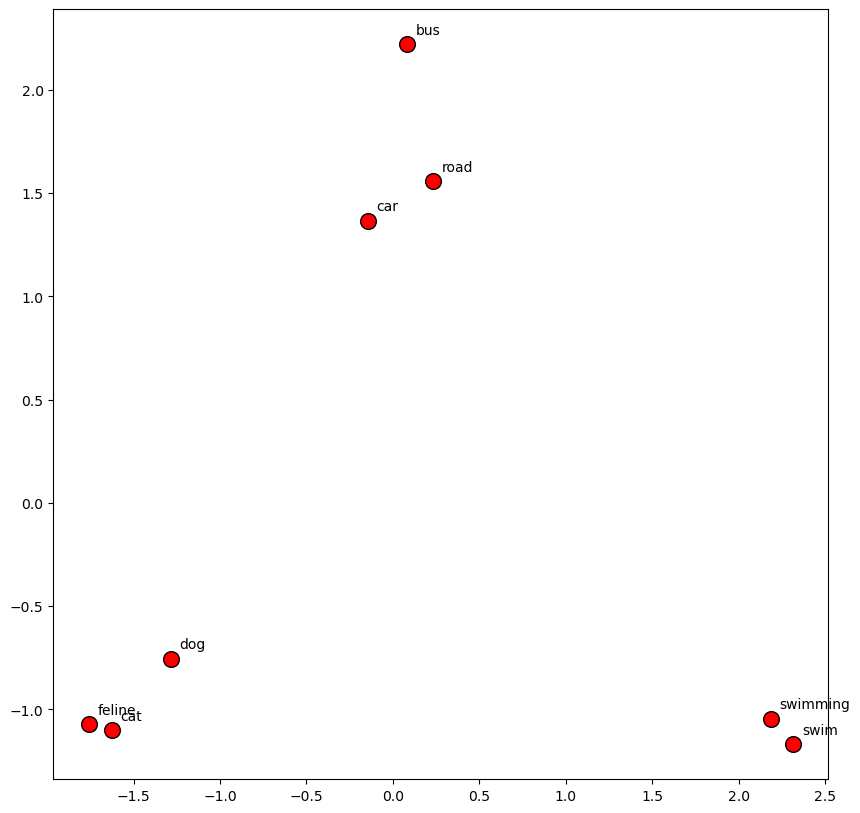

In [440]:
display_pca_scatterplot(word_vectors, ['swim', 'swimming', 'cat', 'dog', 'feline', 'road', 'car', 'bus'])


In [441]:
word_vectors.most_similar(positive=['Italy', 'London'], negative=['Rome'], topn=3)


[('UK', 0.623056948184967),
 ('Britain', 0.6016389727592468),
 ('United_Kingdom', 0.5343458652496338)]

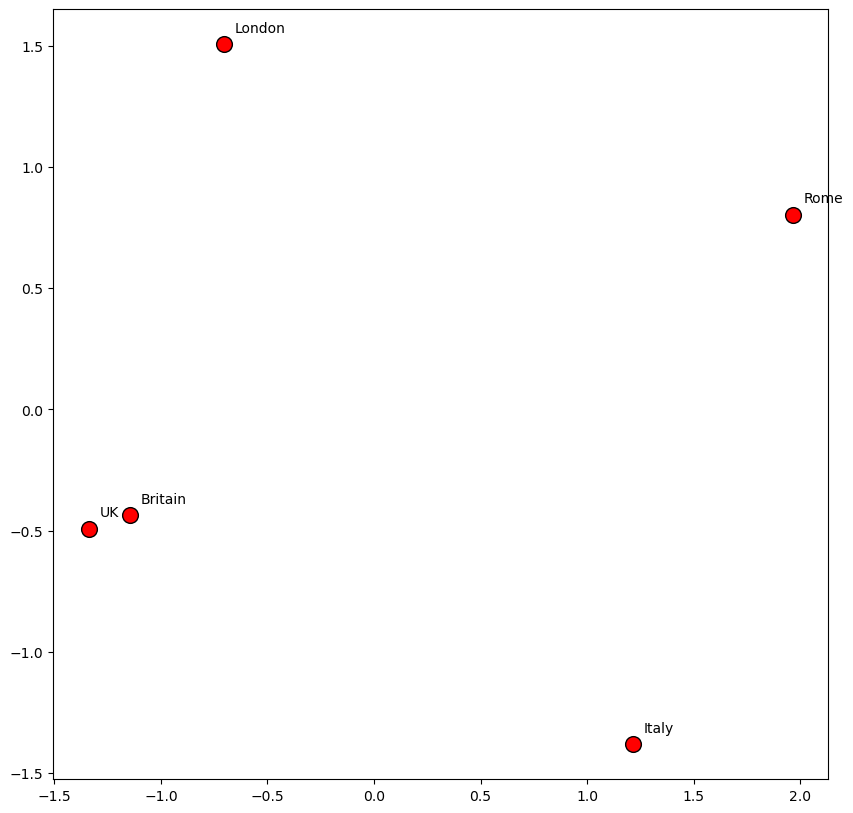

In [442]:
display_pca_scatterplot(word_vectors, ['Rome', 'Italy', 'London', 'Britain', 'UK'])


## 3 Using Pretrained Word Vectors for Classification


In [443]:
word_vectors = KeyedVectors.load_word2vec_format(output, binary=True) # limit=None

print(len(word_vectors))


### 3.1 validation set


In [ ]:
train_df, val_df = train_test_split(train_df, train_size=0.9, random_state=1)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

display(train_df.head())


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_30
0,2016-12-09 17:32:04,Gradle: MessageIOException: Could not write me...,"I wrote a simple test project, which opens por...","[java, sockets, gradle, firewall, apache-mina]","[write, message, firewall]","[write, message, firewall, write, test, projec...","[gradle, write, message]","[write, test, project, open, port, time, exit,...",[java]
1,2016-01-14 08:31:08,User is not authorized to perform: dynamodb:Pu...,I am trying to access DynamoDB from my Node ap...,"[node.js, amazon-web-services, amazon-dynamodb...","[user, authorize, perform, resource]","[user, authorize, perform, resource, try, acce...","[user, authorize, perform, dynamodb, resource]","[try, access, dynamodb, app, deploy, error, au...",[node.js]
2,2013-08-27 11:29:34,How can I change the scroll direction in UICol...,I have a UICollectionView in my storyboard bas...,"[ios, objective-c, scroll, uicollectionview, o...","[change, scroll, direction, uicollectionview]","[change, scroll, direction, uicollectionview, ...","[change, scroll, direction]","[uicollectionview, storyboard, base, app, devi...","[ios, objective-c]"
3,2012-03-06 18:05:30,Splash screen while loading a url in a webview...,"I've got an app, that has 2 activity, the firs...","[android, android-activity, webview, screen, s...","[splash, screen, load, url, webview, app]","[splash, screen, load, url, webview, app, get,...","[splash, screen, load, url, webview, app]","[app, activity, launch, load, url, webview, wo...",[android]
4,2012-10-23 16:47:04,django ajax post 403 forbidden,using django 1.4 im getting a 403 error when i...,"[javascript, ajax, django, http-post, http-sta...","[django, ajax, forbidden]","[django, ajax, im, get, error, try, post, java...",[forbid],"[django, error, try, post, javascript, django,...",[javascript]


In [ ]:
# Set up training data.

feature = 'title' # on va testeer le tokenizer de keras
target = 'top_tags_' + str(NB_TAGS)

X_train = train_df[feature].values
y_train = train_df[target].tolist()

# Set up validation data.
X_val = val_df[feature].values
y_val = val_df[target].tolist()


In [ ]:
# encodage target

def target_encoding(y):
    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y)

    return y_encoded


y_train_encoded = target_encoding(y_train)
y_val_encoded = target_encoding(y_val)

print(y_train_encoded)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### 3.2 tokenization


In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=20000,
                                               filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                                               lower=True)

tokenizer.fit_on_texts(X_train)


In [ ]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)

print(X_train_tokens[0])
print([tokenizer.index_word[x] for x in X_train_tokens[0][:3]])


[217, 9062, 143, 12, 259, 291, 9063, 1, 2979]
['gradle', 'messageioexception', 'could']


In [ ]:
# Review excerpt reconstructed from integer sequence.
tokenizer.sequences_to_texts([X_train_tokens[0]])[0][:300]


'gradle messageioexception could not write message endofstream to firewall'

In [ ]:
# Original review text.
train_df[feature].iloc[0][:300]


'Gradle: MessageIOException: Could not write message [EndOfStream] to 127.0.0.1 (Firewall)?'

In [ ]:
# Get the number of tokens for each text
num_tokens = [len(tokens) for tokens in tokenizer.texts_to_sequences(X_train)]

# Calculate statistics
mean_tokens = np.mean(num_tokens)
median_tokens = np.median(num_tokens)
mode_tokens = max(set(num_tokens), key=num_tokens.count)
std_tokens = np.std(num_tokens)

# Print statistics
print("Mean number of tokens:", mean_tokens)
print("Median number of tokens:", median_tokens)
print("Mode number of tokens:", mode_tokens)
print("Standard deviation of tokens:", std_tokens)


Mean number of tokens: 9.317162246166598
Median number of tokens: 9.0
Mode number of tokens: 8
Standard deviation of tokens: 3.5402243817617434


In [ ]:
# Convert list to DataFrame
df_num_tokens = pd.DataFrame(num_tokens, columns=['num_tokens'])

# Use describe() to get summary statistics
summary_stats = df_num_tokens.describe()

print(summary_stats)


         num_tokens
count  38608.000000
mean       9.317162
std        3.540270
min        2.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       29.000000


In [ ]:
summary_stats = df_num_tokens.loc[df_num_tokens['num_tokens'] > 11, :].describe()

print(summary_stats)

# OK on va prendre jusqu'à 15 inclus


        num_tokens
count  8935.000000
mean     14.357023
std       2.634455
min      12.000000
25%      12.000000
50%      14.000000
75%      15.000000
max      29.000000


### 3.3 Padding


In [ ]:
# Pas indispensable ici, mais bientôt utile

MAX_LEN = 15
X_train = keras.preprocessing.sequence.pad_sequences(X_train_tokens, maxlen=MAX_LEN)


In [ ]:
print(X_train[0])
print(X_train[1])


[   0    0    0    0    0    0  217 9062  143   12  259  291 9063    1
 2979]
[   0    0    0    0    0  132    9   12 3160    1  748 2019 9064   11
  407]


In [ ]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=MAX_LEN)


### 3.4 embedding matrix


In [ ]:
# + 1 to account for padding token.
num_tokens = len(tokenizer.word_index) + 1
print(num_tokens)

# Initialize a matrix of zeroes of size: vocabulary x embedding dimension.
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()


17894


In [ ]:
# Quick visual check.
print(embedding_matrix[tokenizer.word_index['good']][:50])


[ 0.04052734  0.0625     -0.01745605  0.07861328  0.03271484 -0.01263428
  0.00964355  0.12353516 -0.02148438  0.15234375 -0.05834961 -0.10644531
  0.02124023  0.13574219 -0.13183594  0.17675781  0.27148438  0.13769531
 -0.17382812 -0.14160156 -0.03076172  0.19628906 -0.03295898  0.125
  0.25390625  0.12695312 -0.15234375  0.03198242  0.01135254 -0.01361084
 -0.12890625  0.01019287  0.23925781 -0.08447266  0.140625    0.13085938
 -0.04516602  0.06494141  0.02539062  0.05615234  0.24609375 -0.20507812
  0.23632812 -0.00860596 -0.02294922  0.05078125  0.10644531 -0.03564453
  0.08740234 -0.05712891]


### 3.5 trainable embedding layer


In [ ]:
#
trainable=False

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_LEN,
    trainable=trainable
)


### 3.6 custom metric : jaccard


In [ ]:
# Define Jaccard similarity coefficient as a custom metric
# + compact que ma version.
# moins lisible ^^

def jaccard_similarity(y_pred, y_true):
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, dtype=tf.float32))
    union = tf.reduce_sum(tf.cast(tf.clip_by_value(y_true + y_pred, 0, 1), dtype=tf.float32))
    return intersection / (union + tf.keras.backend.epsilon())

# Compile model with custom metric
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', jaccard_similarity])


### 3.7 compilation d'un premier modele


In [ ]:
tf.random.set_seed(0)

model = keras.Sequential()

# This layer will output a sequence of 300-dimension *vectors*, one for each element in the input sequence.
model.add(embedding_layer)

# This layer will calculate an average of those vectors.
model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(150, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(75, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(NB_TAGS, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', jaccard_similarity])


In [ ]:
model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 15, 300)           5368200   
                                                                 
 global_average_pooling1d_20  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_60 (Dense)            (None, 150)               45150     
                                                                 
 dense_61 (Dense)            (None, 75)                11325     
                                                                 
 dense_62 (Dense)            (None, 30)                2280      
                                                                 
Total params: 5,426,955
Trainable params: 5,426,955
Non-trainable params: 0
___________________________________________

In [ ]:
history = model.fit(X_train, y_train_encoded, epochs=30, batch_size=512, validation_data=(X_val, y_val_encoded))


Epoch 1/20


76/76 [==============================] - 11s 131ms/step - loss: 0.3257 - accuracy: 0.0602 - jaccard_similarity: 0.0357 - val_loss: 0.1691 - val_accuracy: 0.0942 - val_jaccard_similarity: 0.0337
Epoch 2/20
76/76 [==============================] - 9s 115ms/step - loss: 0.1675 - accuracy: 0.0998 - jaccard_similarity: 0.0368 - val_loss: 0.1658 - val_accuracy: 0.0886 - val_jaccard_similarity: 0.0370
Epoch 3/20
76/76 [==============================] - 8s 110ms/step - loss: 0.1650 - accuracy: 0.0976 - jaccard_similarity: 0.0385 - val_loss: 0.1646 - val_accuracy: 0.0942 - val_jaccard_similarity: 0.0384
Epoch 4/20
76/76 [==============================] - 9s 120ms/step - loss: 0.1638 - accuracy: 0.1052 - jaccard_similarity: 0.0398 - val_loss: 0.1640 - val_accuracy: 0.0942 - val_jaccard_similarity: 0.0394
Epoch 5/20
76/76 [==============================] - 9s 121ms/step - loss: 0.1630 - accuracy: 0.1100 - jaccard_similarity: 0.0408 - val_loss: 0.1635 - val_accuracy: 0.0942 - val_jaccard_similarit

### 3.8 Visualisation


In [ ]:
# add jaccard ?

def plot_train_vs_val_performance(history):
  training_losses = history.history['loss']
  validation_losses = history.history['val_loss']

  training_accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']

  epochs = range(1, len(training_losses) + 1)

  import matplotlib.pyplot as plt
  fig, (ax1, ax2) = plt.subplots(2)
  fig.set_figheight(15)
  fig.set_figwidth(15)
  fig.tight_layout(pad=5.0)

  # Plot training vs. validation loss.
  ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
  ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
  ax1.title.set_text('Training vs. Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # PLot training vs. validation accuracy.
  ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
  ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
  ax2.title.set_text('Training vs. Validation Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.show()

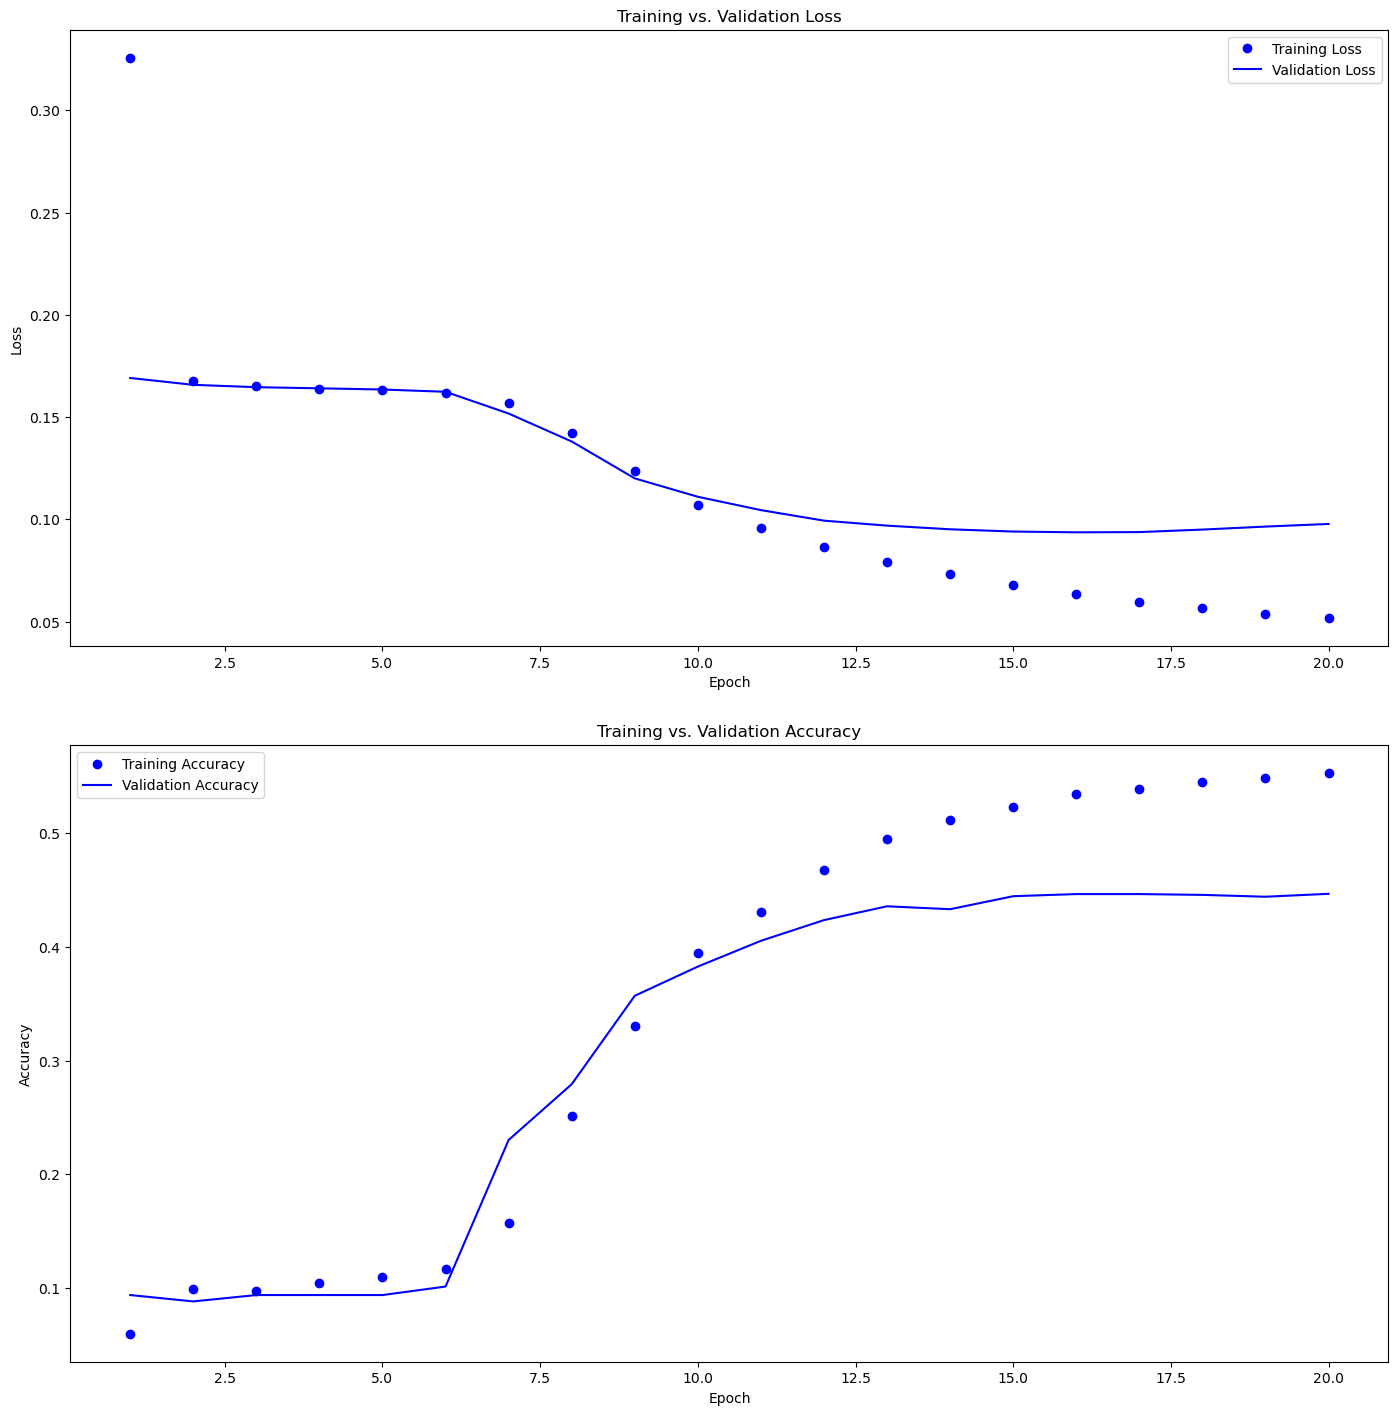

In [ ]:
plot_train_vs_val_performance(history)


### 3.9 Entrainement d'un modèle avec early stop


In [ ]:
# (pour eviter l'overfitting)

# overfitting apres 15-16 iterations (epochs) (sur title_nltk[::2])
# apres 9 (loss) 11-13 (epochs sur dataset complet (feature=title_nltk)

# si trainable=False (embedding_layer), le plateau (validation) est moins prononcé. 11-16 ?
# apres 10-11 si trainable=True (embedding_layer)

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_LEN,
    trainable=trainable,
    mask_zero=True
)

model = keras.Sequential()

model.add(embedding_layer)

model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(150, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(75, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(NB_TAGS, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', jaccard_similarity])

model.fit(X_train, y_train_encoded, epochs=11, batch_size=512, validation_data=(X_val, y_val_encoded))


Epoch 1/11
76/76 [==============================] - 10s 125ms/step - loss: 0.3145 - accuracy: 0.0617 - jaccard_similarity: 0.0358 - val_loss: 0.1695 - val_accuracy: 0.0942 - val_jaccard_similarity: 0.0331
Epoch 2/11
76/76 [==============================] - 9s 120ms/step - loss: 0.1673 - accuracy: 0.1034 - jaccard_similarity: 0.0379 - val_loss: 0.1656 - val_accuracy: 0.1112 - val_jaccard_similarity: 0.0383
Epoch 3/11
76/76 [==============================] - 9s 121ms/step - loss: 0.1644 - accuracy: 0.1070 - jaccard_similarity: 0.0403 - val_loss: 0.1638 - val_accuracy: 0.1170 - val_jaccard_similarity: 0.0408
Epoch 4/11
76/76 [==============================] - 9s 119ms/step - loss: 0.1589 - accuracy: 0.1661 - jaccard_similarity: 0.0499 - val_loss: 0.1534 - val_accuracy: 0.2037 - val_jaccard_similarity: 0.0647
Epoch 5/11
76/76 [==============================] - 9s 121ms/step - loss: 0.1420 - accuracy: 0.2363 - jaccard_similarity: 0.0917 - val_loss: 0.1336 - val_accuracy: 0.2853 - val_jaccar

### 3.10 Evaluation


In [ ]:
X_test = test_df[feature].values
y_test = test_df[target].tolist()

y_test_encoded = target_encoding(y_test)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN)

model.evaluate(X_test, y_test_encoded)


149/149 [==============================] - 0s 3ms/step - loss: 0.0966 - accuracy: 0.4428 - jaccard_similarity: 0.3199


[0.09656782448291779, 0.4428361654281616, 0.3199457824230194]

In [ ]:
# just to be sure

jaccard_similarity(model.predict(X_test), y_test_encoded)

# =0.32 sur dataset complet, trainable=False  (11 epochs)
# =0.31942642 sur dataset complet, trainable=True   (11 epochs)

# Pas de différence


  8/149 [>.............................] - ETA: 1s 

149/149 [==============================] - 1s 3ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.31942642>

In [52]:
def predict_tags(text, tokenizer=tokenizer, maxlen=MAX_LEN):
    seqs = tokenizer.texts_to_sequences([text])
    print(len(seqs))
    print(seqs)
    for seq in seqs:
        print(seq)
        print([tokenizer.index_word[x] for x in seq])

    seqs = keras.preprocessing.sequence.pad_sequences(seqs, maxlen=maxlen)

    return model.predict(seqs)


tags = predict_tags(text="The best the best sea food apple pie")


1
[[5, 264, 5, 264, 11460, 901, 2809]]
[5, 264, 5, 264, 11460, 901, 2809]
['the', 'best', 'the', 'best', 'food', 'apple', 'pie']


1/1 [==============================] - 0s 101ms/step


In [53]:
pprint(tags)
print(tags.shape)


array([[1.5653820e-03, 2.2178479e-02, 1.8514888e-02, 1.5714066e-04,
        1.8421440e-04, 6.3859695e-03, 2.9837834e-03, 1.4614133e-02,
        6.6838954e-03, 1.4283249e-02, 6.7845192e-03, 1.9467773e-03,
        3.4622577e-01, 1.4877859e-02, 7.0009474e-03, 5.9581618e-03,
        2.0997271e-02, 2.2192106e-02, 3.6646992e-03, 2.5628216e-03,
        5.9289932e-02, 2.8351711e-02, 1.3975783e-01, 1.5186860e-02,
        6.2818889e-04, 4.5346525e-03, 8.9267557e-03, 1.4229842e-03,
        7.5910467e-04, 1.1205561e-03]], dtype=float32)
(1, 30)


In [54]:
# OK reste juste à récup / associer les tags equivalents (targets)


# Step 1: Make predictions with the model
predictions = model.predict(X_test[:25])

# Step 2: Get the indices of the top n most probable tags
n = 5  # Number of top tags to return
top_n_indices = np.argsort(predictions, axis=1)[:, -n:]

# Step 3: Get the associated tags
associated_tags = []
for indices in top_n_indices:
    tags = [all_tags[i] for i in indices]
    associated_tags.append(tags)

# Print associated tags for each input text
for i, tags in enumerate(associated_tags):
    print(f"Top {n} tags for input text {i + 1}: {', '.join(tags)}")


1/1 [==============================] - 0s 74ms/step
Top 5 tags for input text 1: spring-boot, large-language-model, flask, python, langchain
Top 5 tags for input text 2: google-chrome, upgrade, flask, amazon-web-services, langchain
Top 5 tags for input text 3: lombok, google-chrome, java-21, eclipse, large-language-model
Top 5 tags for input text 4: spring-security, compiler-errors, flask, langchain, eclipse
Top 5 tags for input text 5: werkzeug, lombok, llama-index, large-language-model, java-21
Top 5 tags for input text 6: spring-security, langchain, upgrade, eclipse, amazon-web-services
Top 5 tags for input text 7: lombok, chatbot, eclipse, java-21, large-language-model
Top 5 tags for input text 8: python, compiler-errors, spring-boot, importerror, upgrade
Top 5 tags for input text 9: amazon-web-services, compiler-errors, chatbot, flask, langchain
Top 5 tags for input text 10: google-chrome, flask, eclipse, large-language-model, langchain
Top 5 tags for input text 11: werkzeug, pyth

### Comparaison


#### word2vec + svm


In [ ]:
X_train = train_df[feature].values
y_train = train_df[target].tolist()

# Set up validation data.
X_val = val_df[feature].values
y_val = val_df[target].tolist()

In [ ]:
# pas nativement mutilabel -> approche one vs rest via MultiOutputClassifier()

def logistic_regression_classifier(train_df=train_df, feature='title_nltk', dict=standard_dict_title,
                                   target='top_tags_50', test_df=test_df):

    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].tolist()

    # training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)

    # target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)

    # Create a Logistic Regression classifier
    logistic_reg = LogisticRegression(random_state=42)

    # Create a MultiOutputClassifier with the Logistic Regression classifier
    multi_output_classifier = MultiOutputClassifier(logistic_reg)

    # Fit the MultiOutputClassifier to your training data
    multi_output_classifier.fit(X_bow_matrix, y_encoded)

    # Evaluate the model using a scorer
    scorer = custom_jacc_scorer
    score = scorer(multi_output_classifier, X_bow_matrix, y_encoded)
    print("Score : ", score)


    return multi_output_classifier, mlb


multi_output_classifier, mlb_50 = logistic_regression_classifier()


## 4 BERT


In [102]:
train_df, test_df = create_top_n_tags_feature(data=raw_data, n=NB_TAGS, slice=2, df_freq=df_freq)


(47665, 9) 



In [103]:
qa = pipeline("question-answering")

context=test_df['body'][1]

question = "What topics is this about ?"

reponse = qa(question=question, context=context)


No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForQuestionAnswering.

All the weights of TFDistilBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [104]:
print(context)


I have to work through a proxy at the office and when I press (Ctrl+Shift+P), type Install and try to load a package list, I get the error "Package Control: There are no packages available for installation."  
In my 'Package Control.sublime-settings' I have:
{
    "auto_upgrade_last_run": 1345569476,
    "http_proxy": "http://user_name:password@<proxy-name>:<proxy_port>"
}

What am I missing OR what is a better option for me to control my system using the proxy. Once I get home I typically have to disable these proxies. Is there a truly system-wide way to make it use a proxy and then disable the proxy with a single command or click?
Also this is in Ubuntu 12.04.
EDIT: Sublime Text Package Manager has been updated to include options for working through a proxy, you can find this in the package settings.



In [105]:
print(reponse)

# Pas mal, mais on n'est plus vraiment dans le supervisé


{'score': 0.013762914575636387, 'start': 657, 'end': 669, 'answer': 'Ubuntu 12.04'}


In [ ]:
# fine tunons


## Ressources


In [106]:
# Word2vec
# https://colab.research.google.com/github/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_word_vectors.ipynb#scrollTo=SBQlbyiVY3WJ


